# Bike Sharing Demand Prediction

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.



- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

## EDA 및 전처리

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [4]:
test = pd.read_csv("test.csv")
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


- train 데이터 10885개
- test 데이터 6492개

#### 범주형/연속형 데이터 구분

- 범주형: season, holiday, workingday, weather
- 연속형: datetime, temp, atemp, humidity, windspeed

In [5]:
set(train.season)

{1, 2, 3, 4}

In [6]:
set(train.holiday)

{0, 1}

In [7]:
set(train.workingday)

{0, 1}

In [8]:
set(train.weather)

{1, 2, 3, 4}

#### Datetime 변수 전처리

In [9]:
train.datetime = pd.to_datetime(train.datetime)

In [10]:
train['year'] = train.datetime.apply(lambda x : x.year)

In [11]:
train['month'] = train.datetime.apply(lambda x : x.month)

In [12]:
train['hour'] = train.datetime.apply(lambda x : x.hour)

In [13]:
train['day'] = train.datetime.apply(lambda x : x.day)

In [14]:
train['y_m_d'] = train.datetime.apply(lambda x : x.date())

In [15]:
train['day_of_week'] = train.datetime.apply(lambda x : x.weekday())

In [16]:
train = train.drop(columns='datetime')

In [17]:
train.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,y_m_d,day_of_week
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,2012-12-19,2
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,20,19,2012-12-19,2
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,21,19,2012-12-19,2
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,22,19,2012-12-19,2
10885,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,23,19,2012-12-19,2


#### 요일에 따른 자전거 대여 방식별 대여횟수

In [18]:
pivot = train[['day_of_week','casual','registered','count']].pivot_table(index='day_of_week',
                                                                 values=['casual','registered','count'], aggfunc=sum)
pivot

,casual,count,registered
day_of_week,,,
0,46288,295296,249008
1,35365,291985,256620
2,34931,292226,257295
3,37283,306401,269118
4,47402,302504,255102
5,100782,311518,210736
6,90084,285546,195462


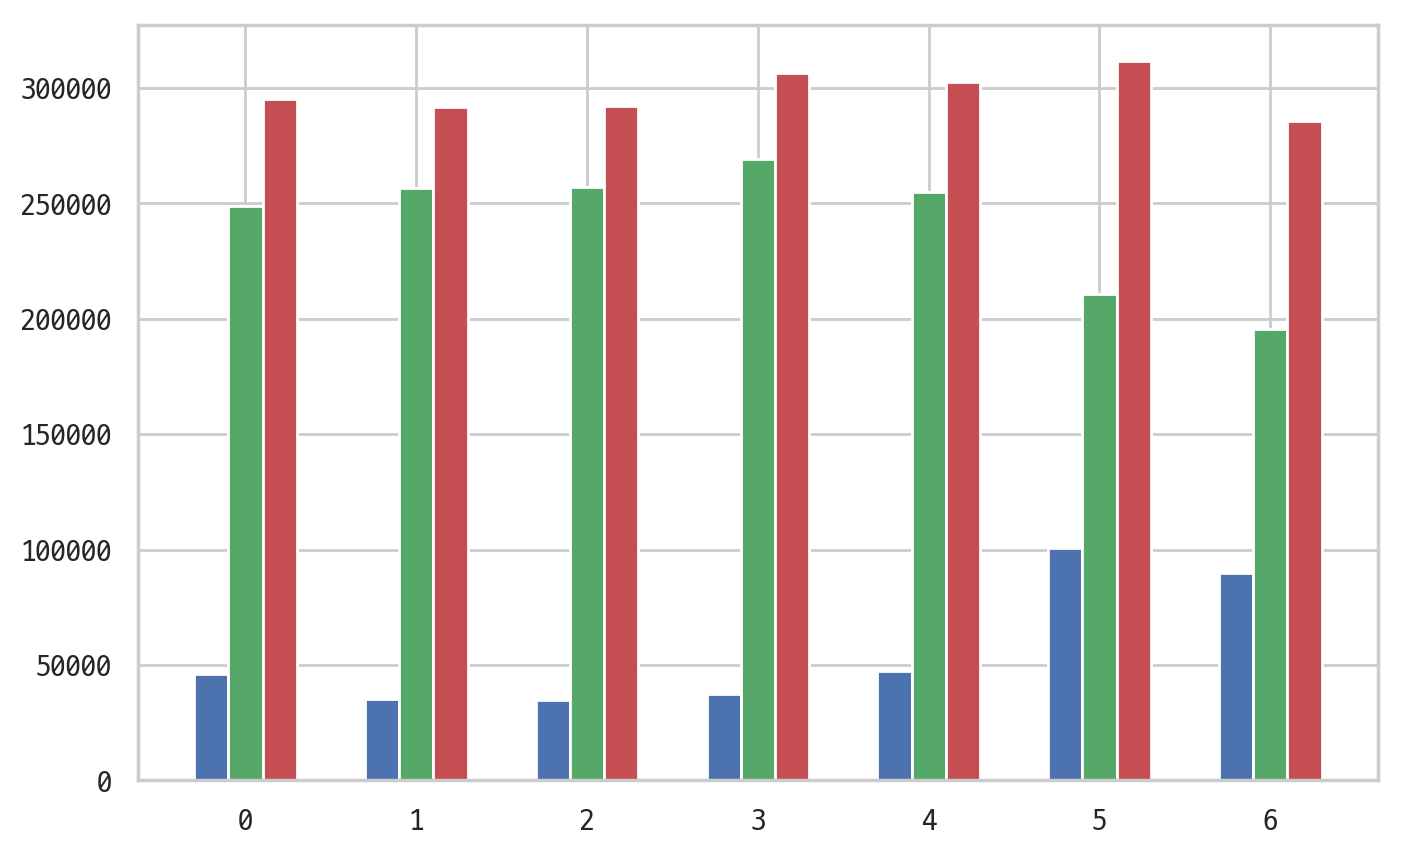

In [19]:
plot = plt.subplot(111)
plot.bar(pivot.index.values-0.2, pivot.values[:,0], width=0.2, color='b', align='center') #casual
plot.bar(pivot.index.values, pivot.values[:,2], width=0.2, color='g', align='center') #registered
plot.bar(pivot.index.values+0.2, pivot.values[:,1], width=0.2, color='r', align='center') #count
plt.show()

> registered로 자전거를 대여하는 빈도수는 평일에 더 많고,
casual로 자전거를 대여하는 빈도수는 주말에 더 많음을 알 수 있다.

>모두 합친 count는 요일에 관계 없이 대체적으로 비슷한 분포를 보인다.

#### 일, 월, 시간별 자전거 대여횟수의 평균

In [20]:
day_count = train[['day','count']].groupby(by='day').agg(np.mean)
day_count.tail()

,count
day,
15,201.527875
16,191.353659
17,205.660870
18,192.605684
19,192.311847


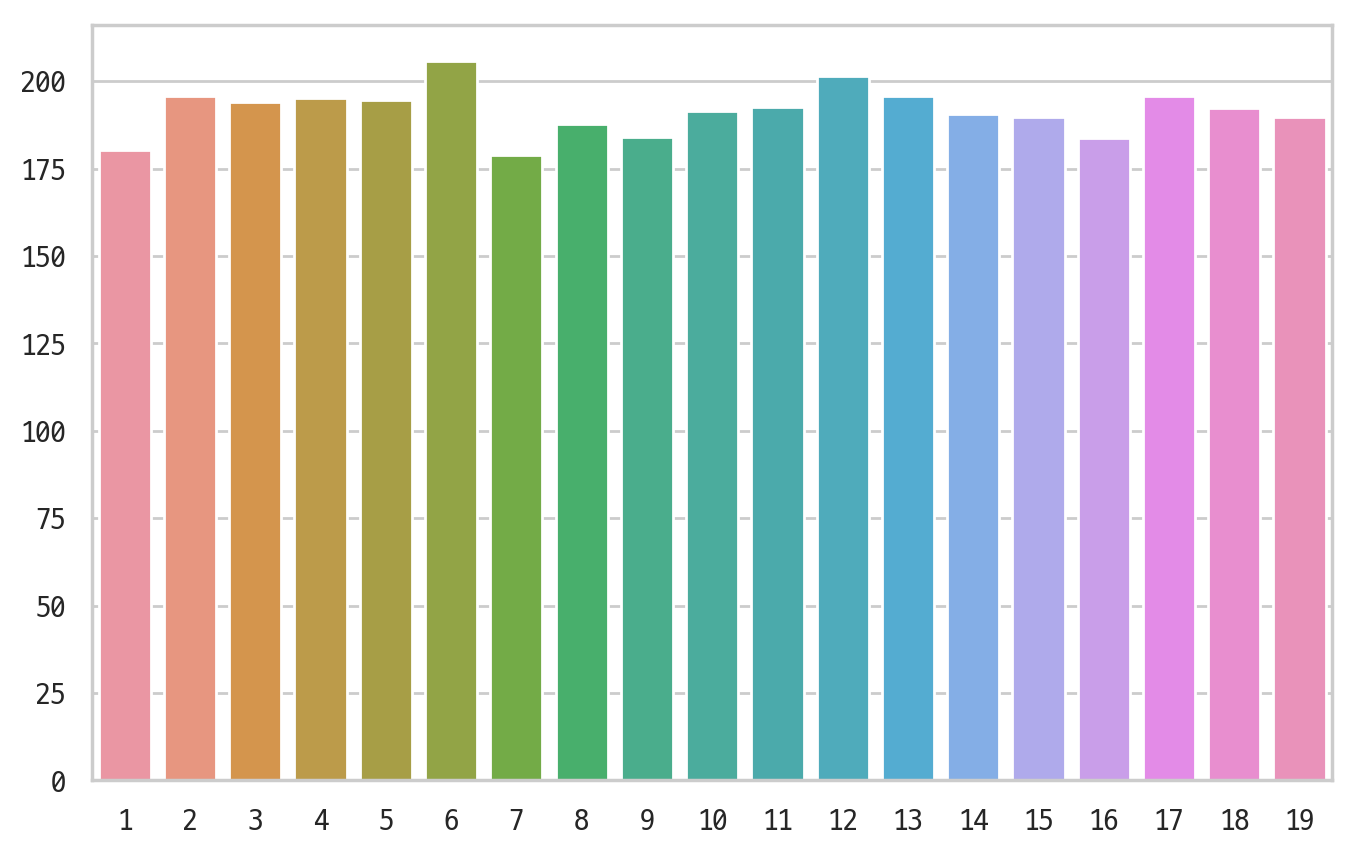

In [21]:
sns.barplot(x=train['day'].value_counts().index, y=day_count.values.flatten())
plt.show()

In [22]:
month_count = train[['month','count']].groupby(by='month').agg(np.mean)
month_count.tail()

,count
month,
8,234.118421
9,233.805281
10,227.699232
11,193.677278
12,175.614035


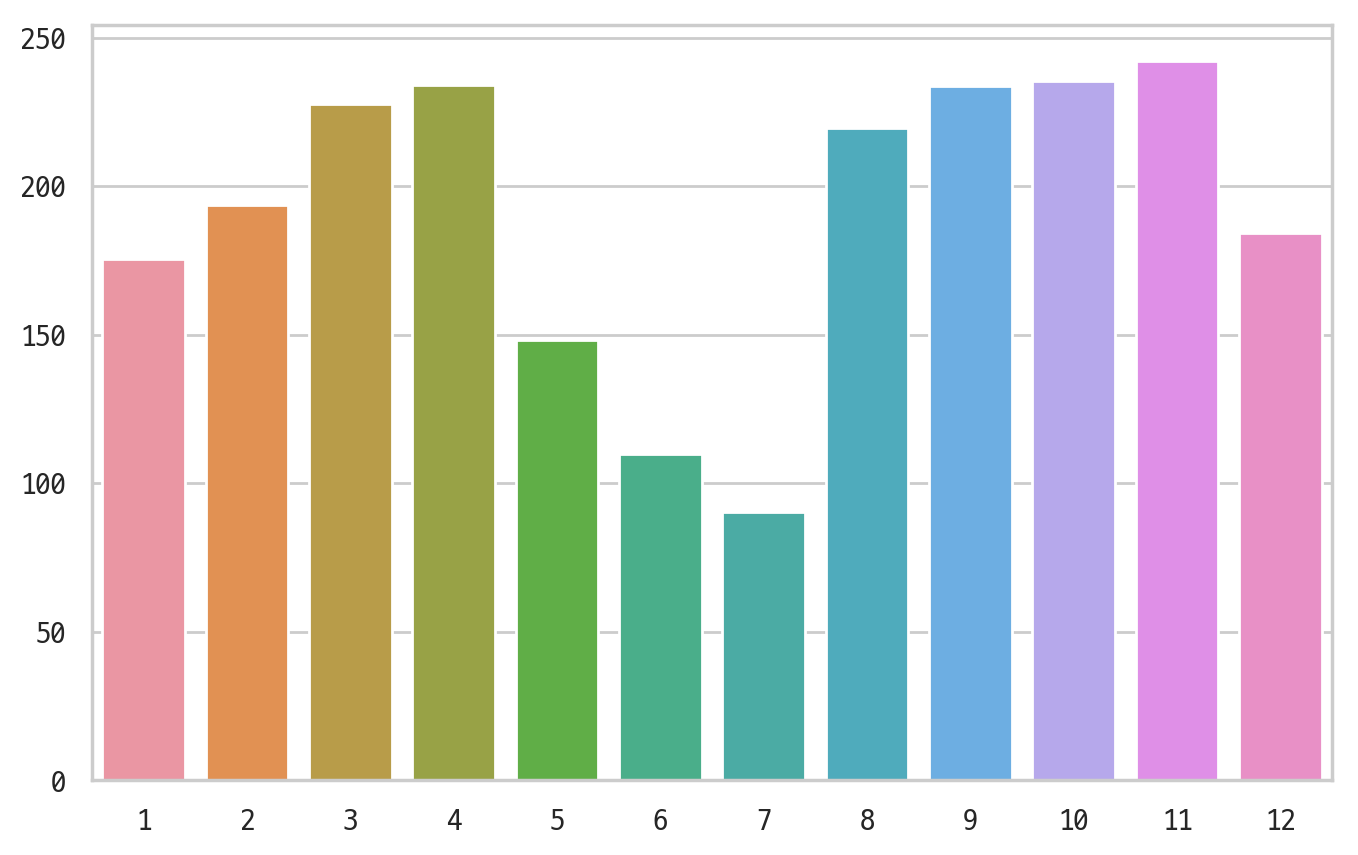

In [23]:
sns.barplot(x=train['month'].value_counts().index, y=month_count.values.flatten())
plt.show()

In [24]:
hour_count = train[['hour','count']].groupby(by='hour').agg(np.mean)
hour_count.tail()

,count
hour,
19,315.278509
20,228.517544
21,173.370614
22,133.576754
23,89.508772


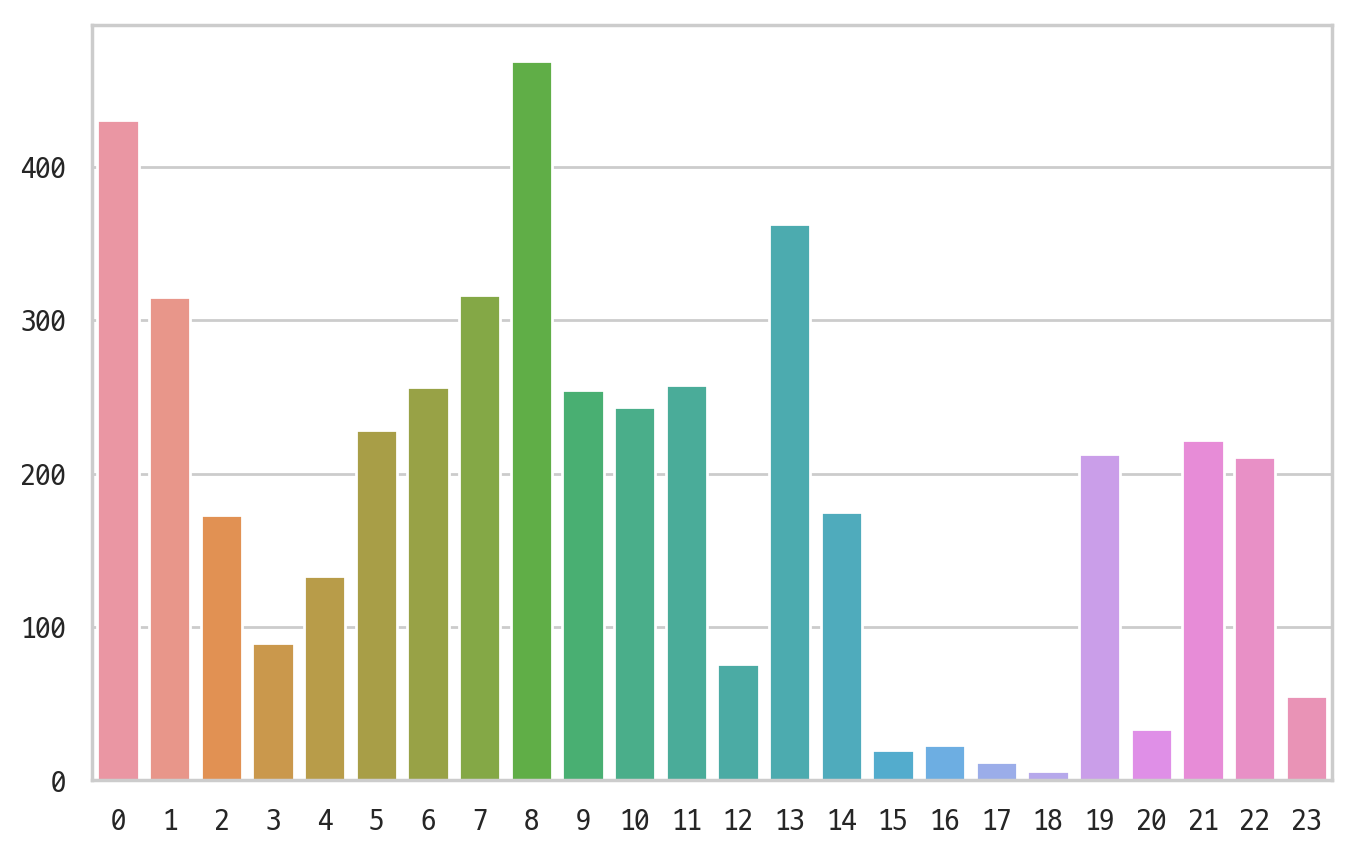

In [25]:
sns.barplot(x=train['hour'].value_counts().index, y=hour_count.values.flatten())
plt.show()

> 날짜는 자전거 대여횟수에 큰 영향을 미치지 않고, 월과 시간이 자전거대여횟수와 상관관계가 있음을 알 수 있다.

#### 결측데이터 처리

이 데이터셋에서 missing value는 humidity와 windspeed에만 존재하는데, nan 값이 아닌 숫자 0으로 된 값들이다.

- humidity 22개
- windspeed 1313개

In [26]:
len(train[train.humidity==0])

22

In [27]:
len(train[train.windspeed==0])

1313

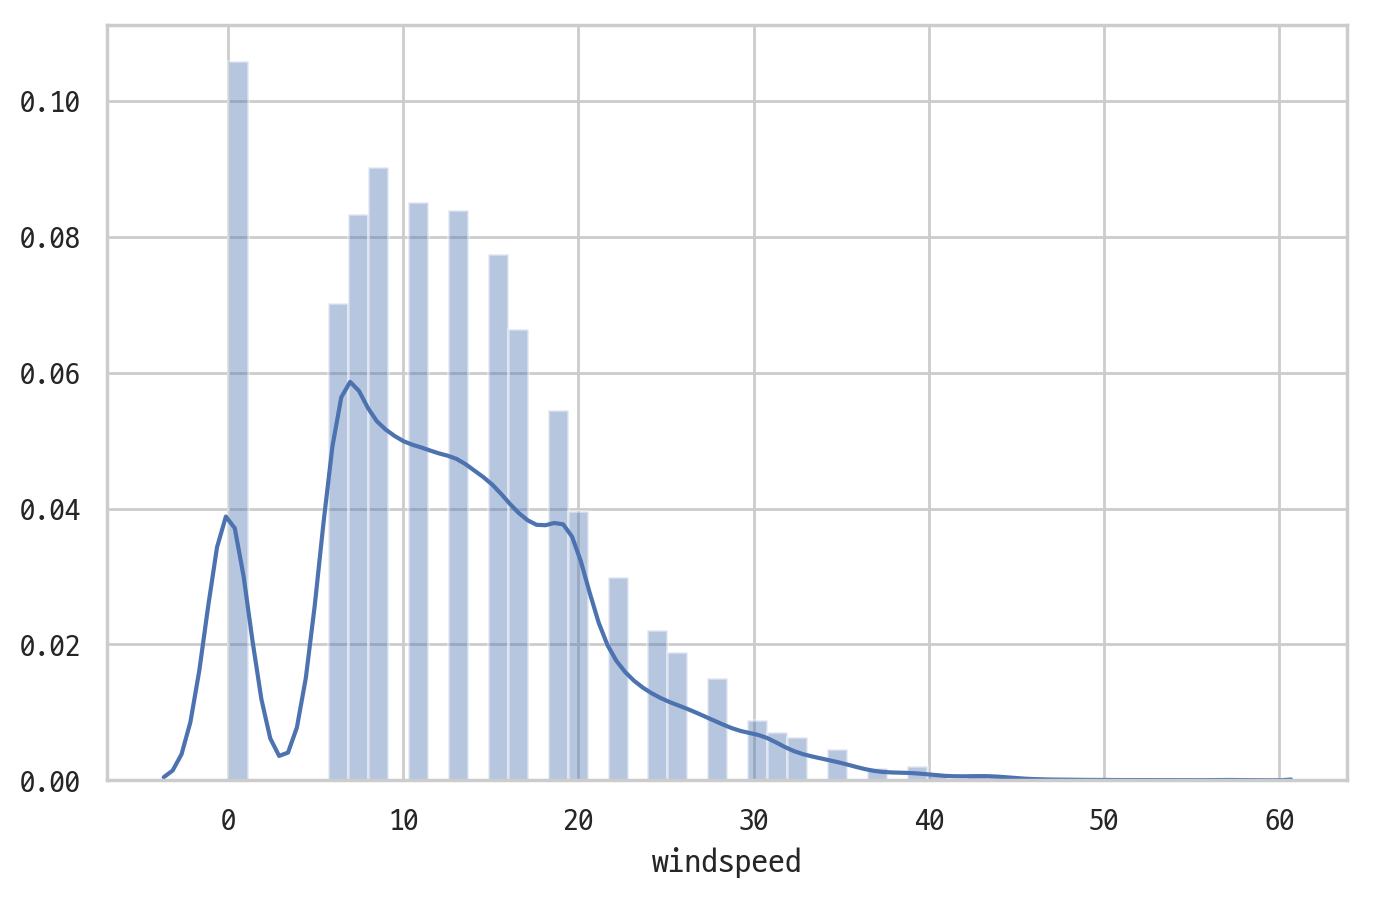

In [28]:
sns.distplot(train.windspeed)
plt.show()

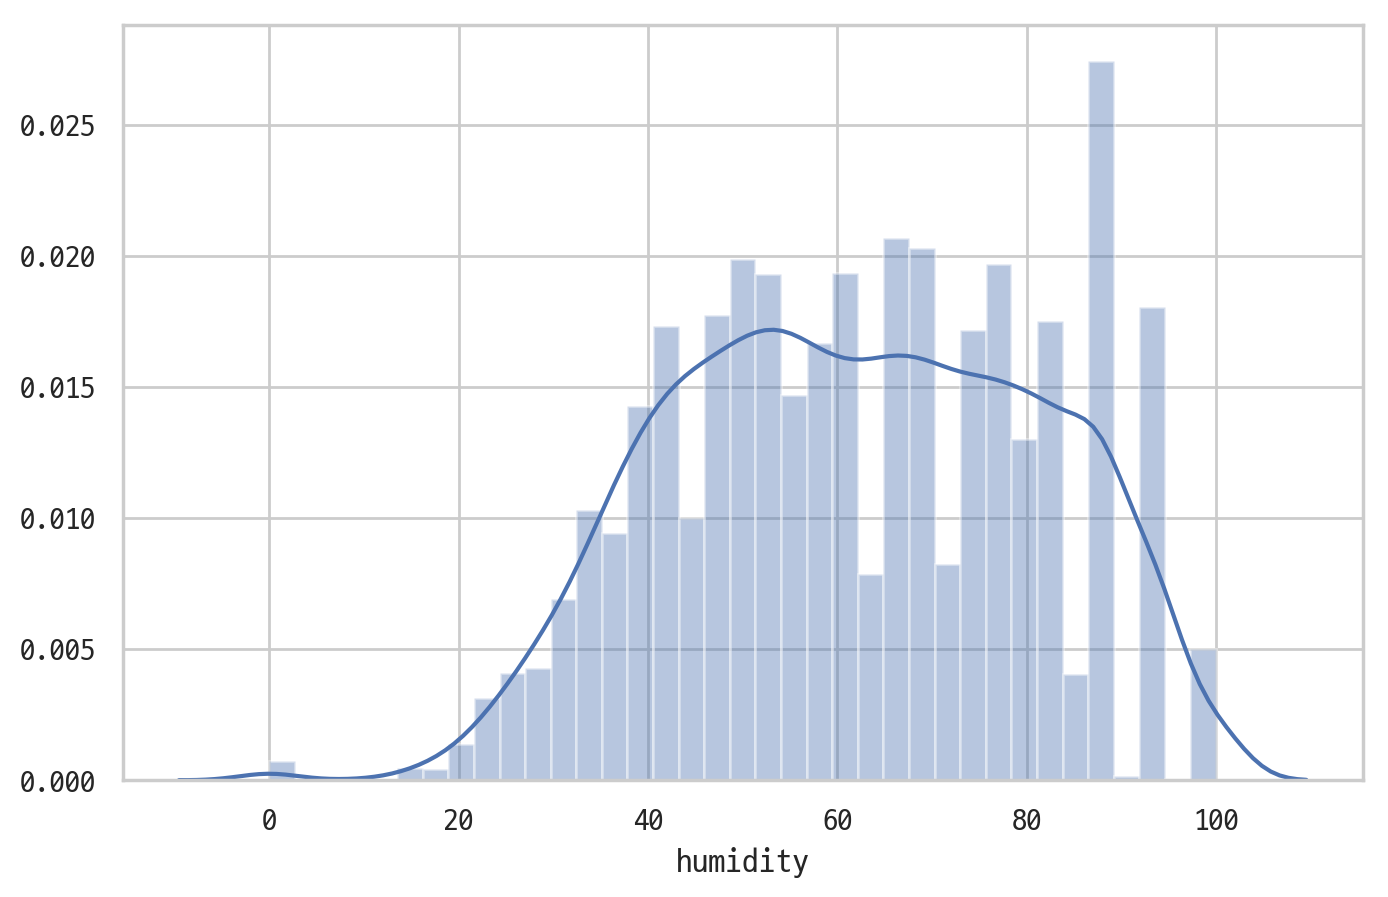

In [29]:
sns.distplot(train.humidity)
plt.show()

우선 windspeed의 결측치는 결측치가 존재하는 날짜의 바람세기 평균값으로 대체하기로 한다.

In [30]:
windspeed_mean = train[['windspeed','y_m_d']].groupby(by='y_m_d').agg('mean')
windspeed_mean = windspeed_mean.rename(columns={'windspeed':'windspeed_mean'})

In [31]:
train = pd.merge(train, windspeed_mean, on='y_m_d')

In [32]:
new = train.windspeed.values

In [33]:
for i in range(len(new)):
    if new[i] == 0:
        new[i] = train.windspeed_mean.values[i]

In [34]:
train.windspeed = new

In [35]:
train = train.drop(columns='windspeed_mean')

In [36]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,y_m_d,day_of_week
0,1,0,0,1,9.84,14.395,81,10.749871,3,13,16,2011,1,0,1,2011-01-01,5
1,1,0,0,1,9.02,13.635,80,10.749871,8,32,40,2011,1,1,1,2011-01-01,5
2,1,0,0,1,9.02,13.635,80,10.749871,5,27,32,2011,1,2,1,2011-01-01,5
3,1,0,0,1,9.84,14.395,75,10.749871,3,10,13,2011,1,3,1,2011-01-01,5
4,1,0,0,1,9.84,14.395,75,10.749871,0,1,1,2011,1,4,1,2011-01-01,5


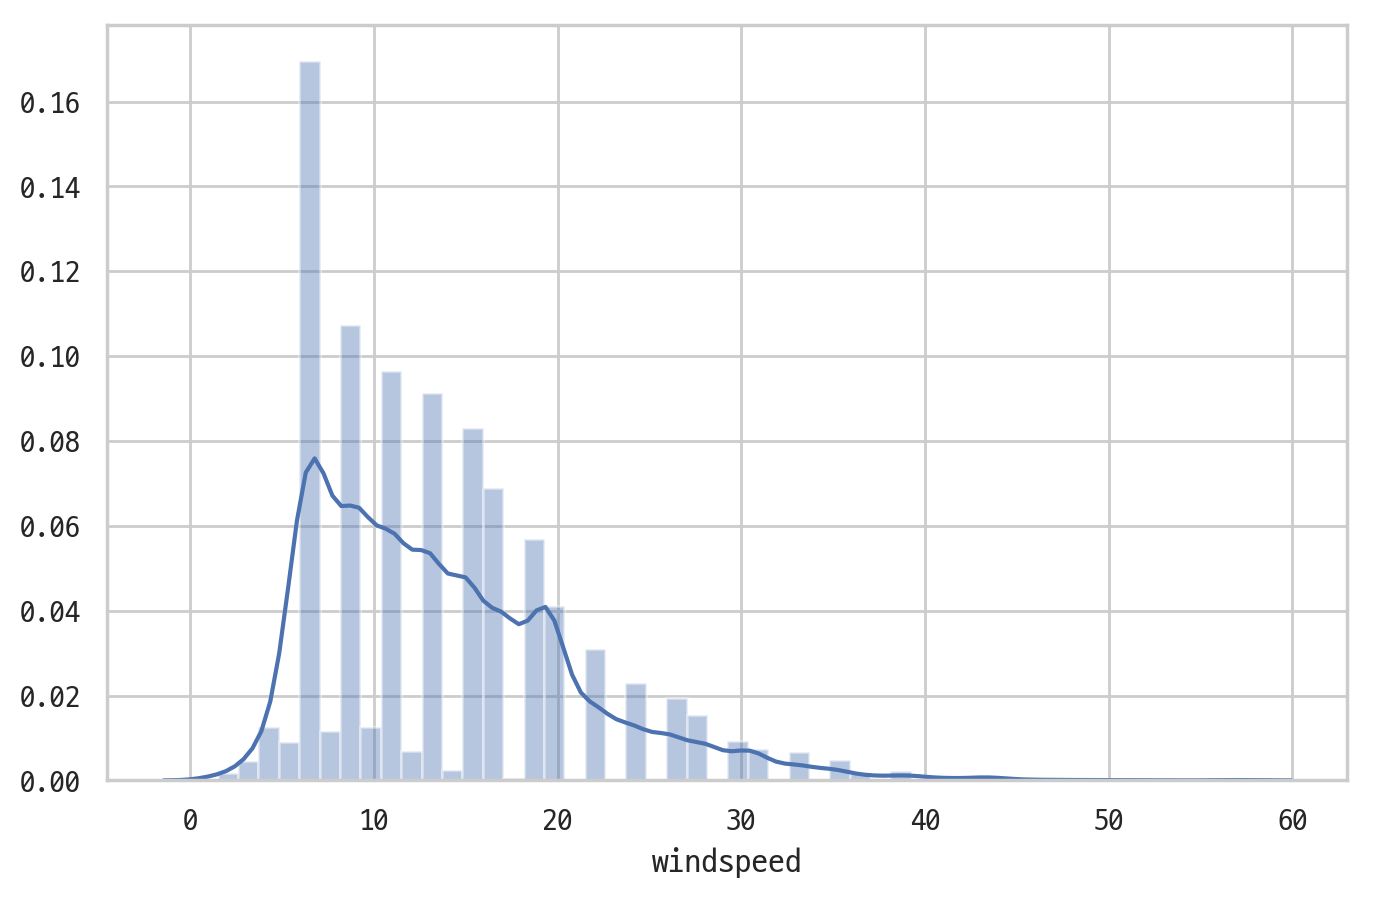

In [37]:
sns.distplot(train.windspeed)
plt.show()

humidity는 결측값 22개가 모두 2011년 3월 10일 하루에 해당하는 결측값임을 알 수 있다.

In [38]:
train[train.humidity==0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,y_m_d,day_of_week
1091,1,0,1,3,13.94,15.910,0,16.9979,3,0,3,2011,3,0,10,2011-03-10,3
1092,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,2011,3,1,10,2011-03-10,3
1093,1,0,1,3,13.94,15.910,0,16.9979,0,1,1,2011,3,2,10,2011-03-10,3
1094,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,2011,3,5,10,2011-03-10,3
1095,1,0,1,3,14.76,16.665,0,22.0028,0,12,12,2011,3,6,10,2011-03-10,3
1096,1,0,1,3,15.58,19.695,0,15.0013,1,36,37,2011,3,7,10,2011-03-10,3
1097,1,0,1,3,15.58,19.695,0,19.0012,1,43,44,2011,3,8,10,2011-03-10,3
1098,1,0,1,3,16.40,20.455,0,15.0013,1,23,24,2011,3,9,10,2011-03-10,3
1099,1,0,1,3,16.40,20.455,0,11.0014,0,17,17,2011,3,10,10,2011-03-10,3
1100,1,0,1,3,16.40,20.455,0,16.9979,6,5,11,2011,3,11,10,2011-03-10,3


In [39]:
1112 - 1091 + 1

22

2011년 3월 10일의 humidity값은 2011년 3월 전체의 humidity 평균값으로 대체하기로 한다.

In [40]:
humidity_mean = train[['humidity','year','month']].groupby(by=['year','month']).agg(np.mean)
humidity_mean.head()

humidity
year month           
2011 1      56.308585
     2      53.580717
     3      55.923767
     4      66.285714
     5      71.421053

In [41]:
train.humidity = train.humidity.replace(0, 55.923767)

In [42]:
train.loc[1091:1112]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,y_m_d,day_of_week
1091,1,0,1,3,13.94,15.910,55.923767,16.9979,3,0,3,2011,3,0,10,2011-03-10,3
1092,1,0,1,3,13.94,15.910,55.923767,16.9979,0,2,2,2011,3,1,10,2011-03-10,3
1093,1,0,1,3,13.94,15.910,55.923767,16.9979,0,1,1,2011,3,2,10,2011-03-10,3
1094,1,0,1,3,14.76,17.425,55.923767,12.9980,1,2,3,2011,3,5,10,2011-03-10,3
1095,1,0,1,3,14.76,16.665,55.923767,22.0028,0,12,12,2011,3,6,10,2011-03-10,3
1096,1,0,1,3,15.58,19.695,55.923767,15.0013,1,36,37,2011,3,7,10,2011-03-10,3
1097,1,0,1,3,15.58,19.695,55.923767,19.0012,1,43,44,2011,3,8,10,2011-03-10,3
1098,1,0,1,3,16.40,20.455,55.923767,15.0013,1,23,24,2011,3,9,10,2011-03-10,3
1099,1,0,1,3,16.40,20.455,55.923767,11.0014,0,17,17,2011,3,10,10,2011-03-10,3
1100,1,0,1,3,16.40,20.455,55.923767,16.9979,6,5,11,2011,3,11,10,2011-03-10,3


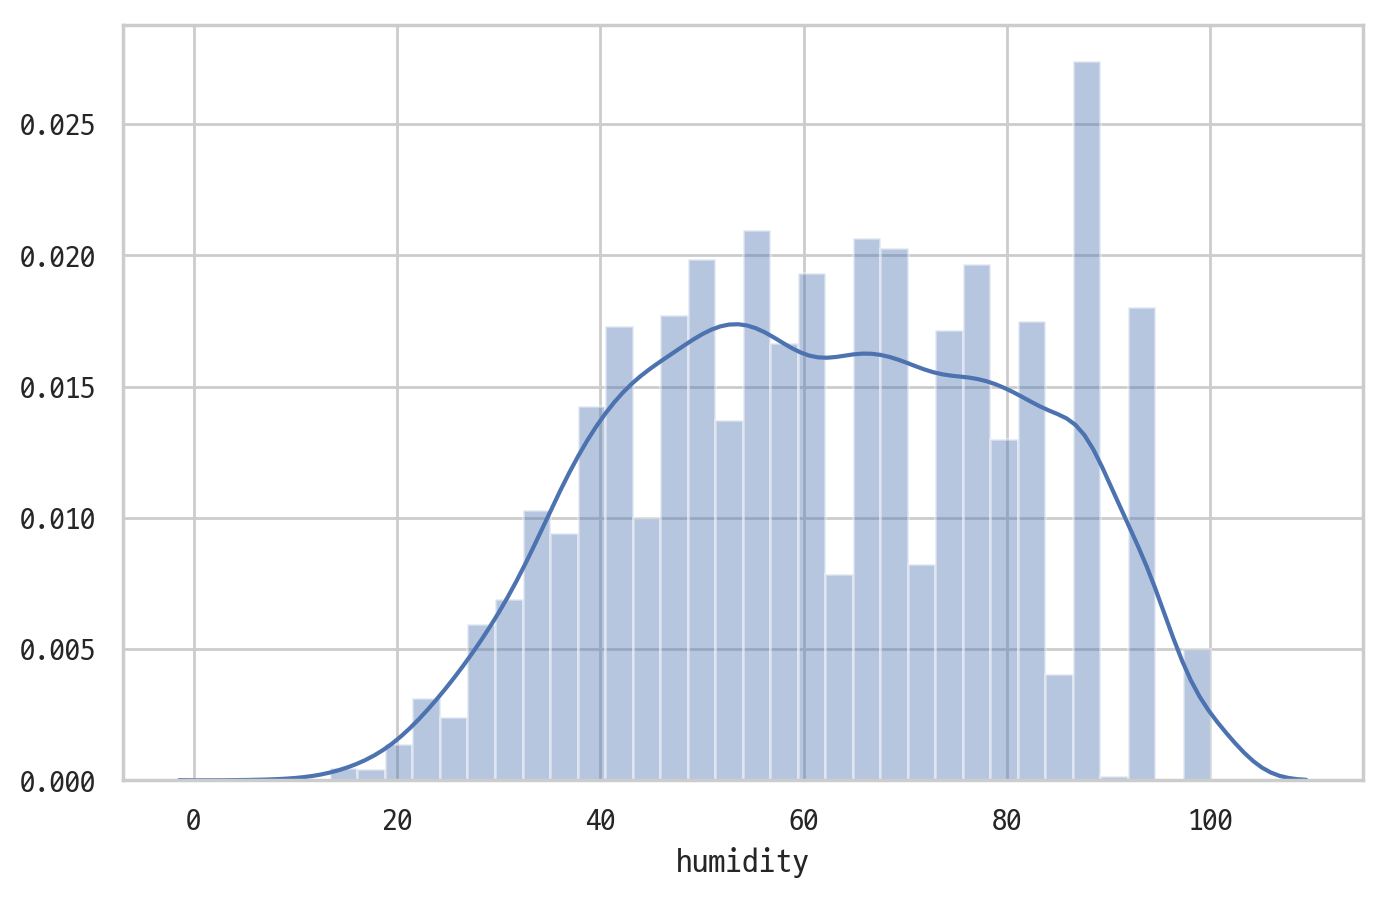

In [43]:
sns.distplot(train.humidity)
plt.show()

## OLS

In [44]:
model_raw = sm.OLS(train['count'], train.drop(columns=['count','casual','registered','y_m_d']))
result_raw = model_raw.fit()
print(result_raw.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     1852.
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:22   Log-Likelihood:                -69776.
No. Observations:               10886   AIC:                         1.396e+05
Df Residuals:                   10873   BIC:                         1.397e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
season        -10.9369      5.381     -2.033      

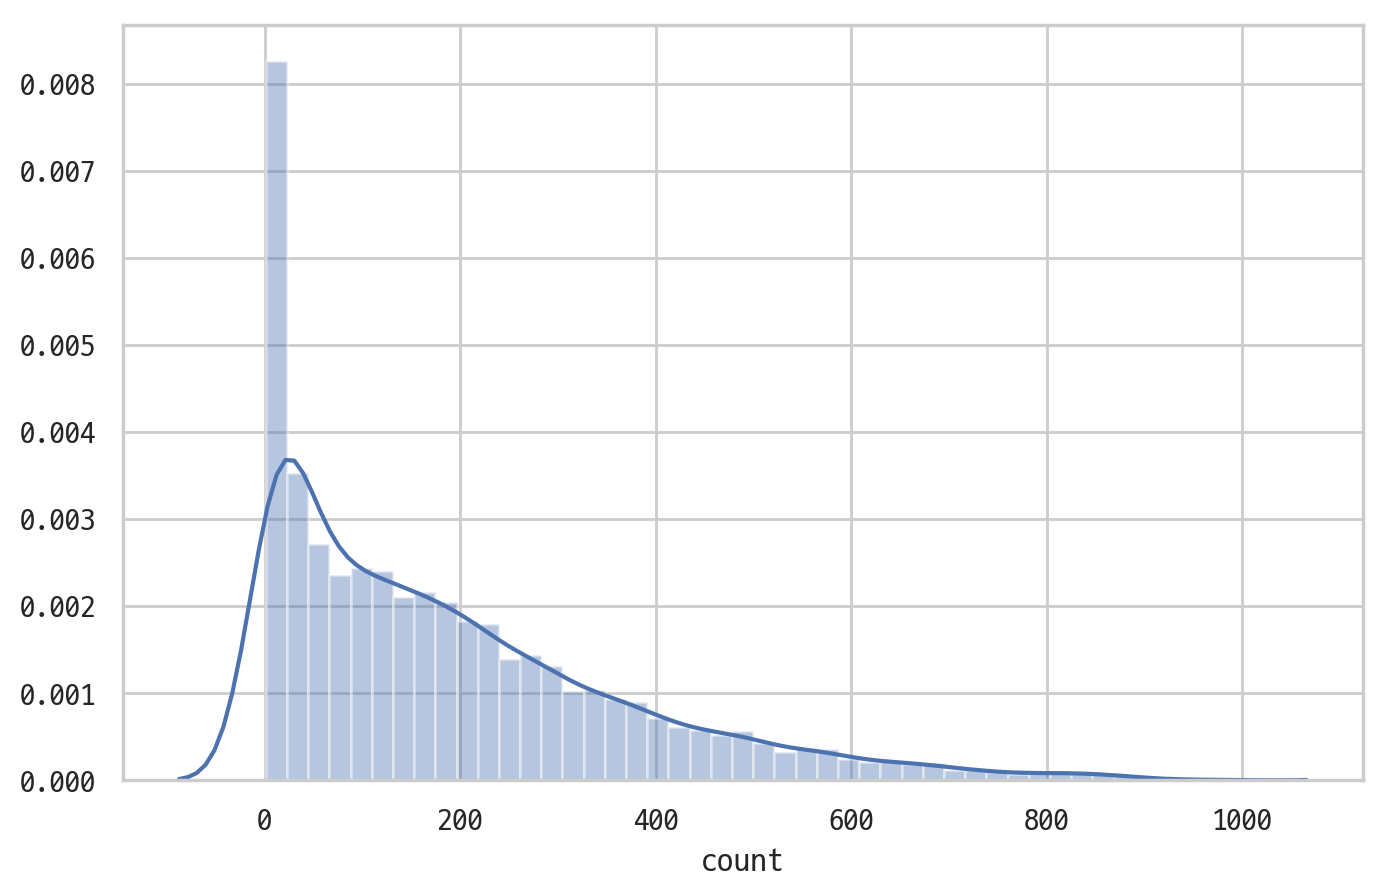

In [45]:
sns.distplot(train['count'])
plt.show()

종속변수가 한쪽으로 강하게 치우쳐 있으므로 로그변환해준다.

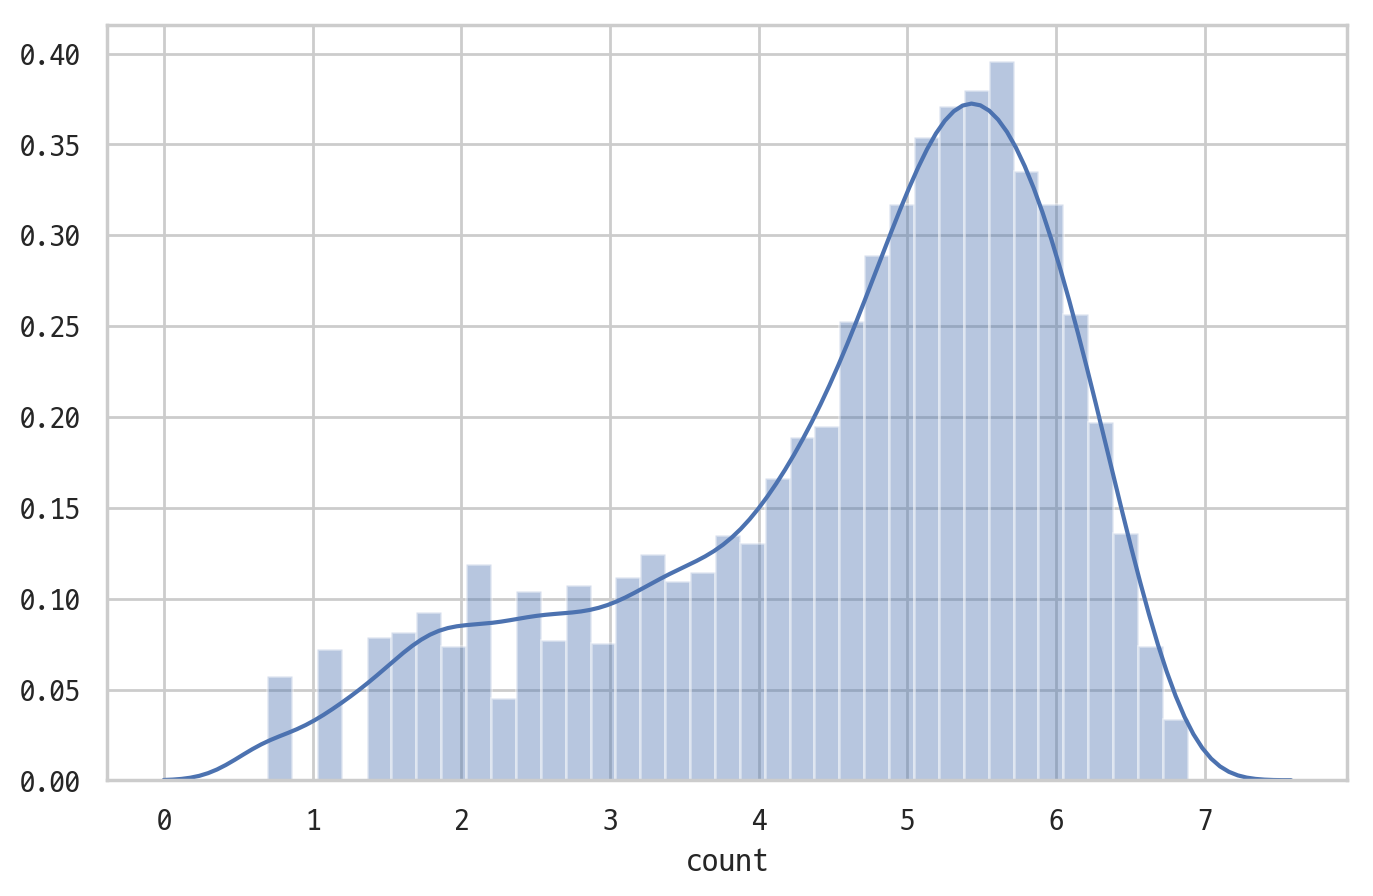

In [46]:
sns.distplot(np.log1p(train['count']))
plt.show()

종속변수에 로그를 취해주고 독립변수에는 정규화 혹은 범주형변수 인코딩을 해주고 나서 돌린 모델은 다음과 같다.

In [47]:
model1 = sm.OLS.from_formula('np.log1p(count) ~ C(season) + C(holiday) + C(workingday) + C(weather) + scale(temp) +\
scale(atemp) + scale(humidity) + scale(windspeed) + C(year) + C(month) + C(hour) + C(day) + C(day_of_week) + 0', train)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     818.4
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:24   Log-Likelihood:                -9444.7
No. Observations:               10886   AIC:                         1.903e+04
Df Residuals:                   10818   BIC:                         1.952e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(season)[1]            1.4823    

> 조건수가 높은 것으로 보아 독립변수들 사이에 상관관계가 존재할 것이 의심되므로 다중공선성 검사를 진행한다.

#### 다중공선성 검사

In [48]:
train_vif = train.drop(columns=['count', 'casual', 'registered', 'y_m_d'])

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif = vif.sort_values(by=["VIF Factor"], ascending=False).reset_index(drop=True)
vif

,VIF Factor,features
0,311.885544,atemp
1,273.965579,temp
2,109.600108,season
3,83.688129,month
4,74.157827,year
5,18.501338,humidity
6,9.188382,day_of_week
7,9.052215,workingday
8,7.685199,weather
9,5.865255,windspeed


다중공선성이 가장 높은 두 변수 atemp와 Temp, 즉 기온과 체감온도는 0.98의 상관계수로 매우 높은 상관관계를 보인다.

따라서 둘 중 하나의 변수는 버려야 한다.

temp 와 atemp 중 어떤 것이 모델에 더 영향을 주는지 확인해본다.

In [50]:
np.corrcoef(train.temp, train.atemp)

array([[1.        , 0.98494811],
       [0.98494811, 1.        ]])

In [51]:
model_partial = sm.OLS.from_formula('count ~ temp + atemp + 0', train)
result_partial = model_partial.fit()

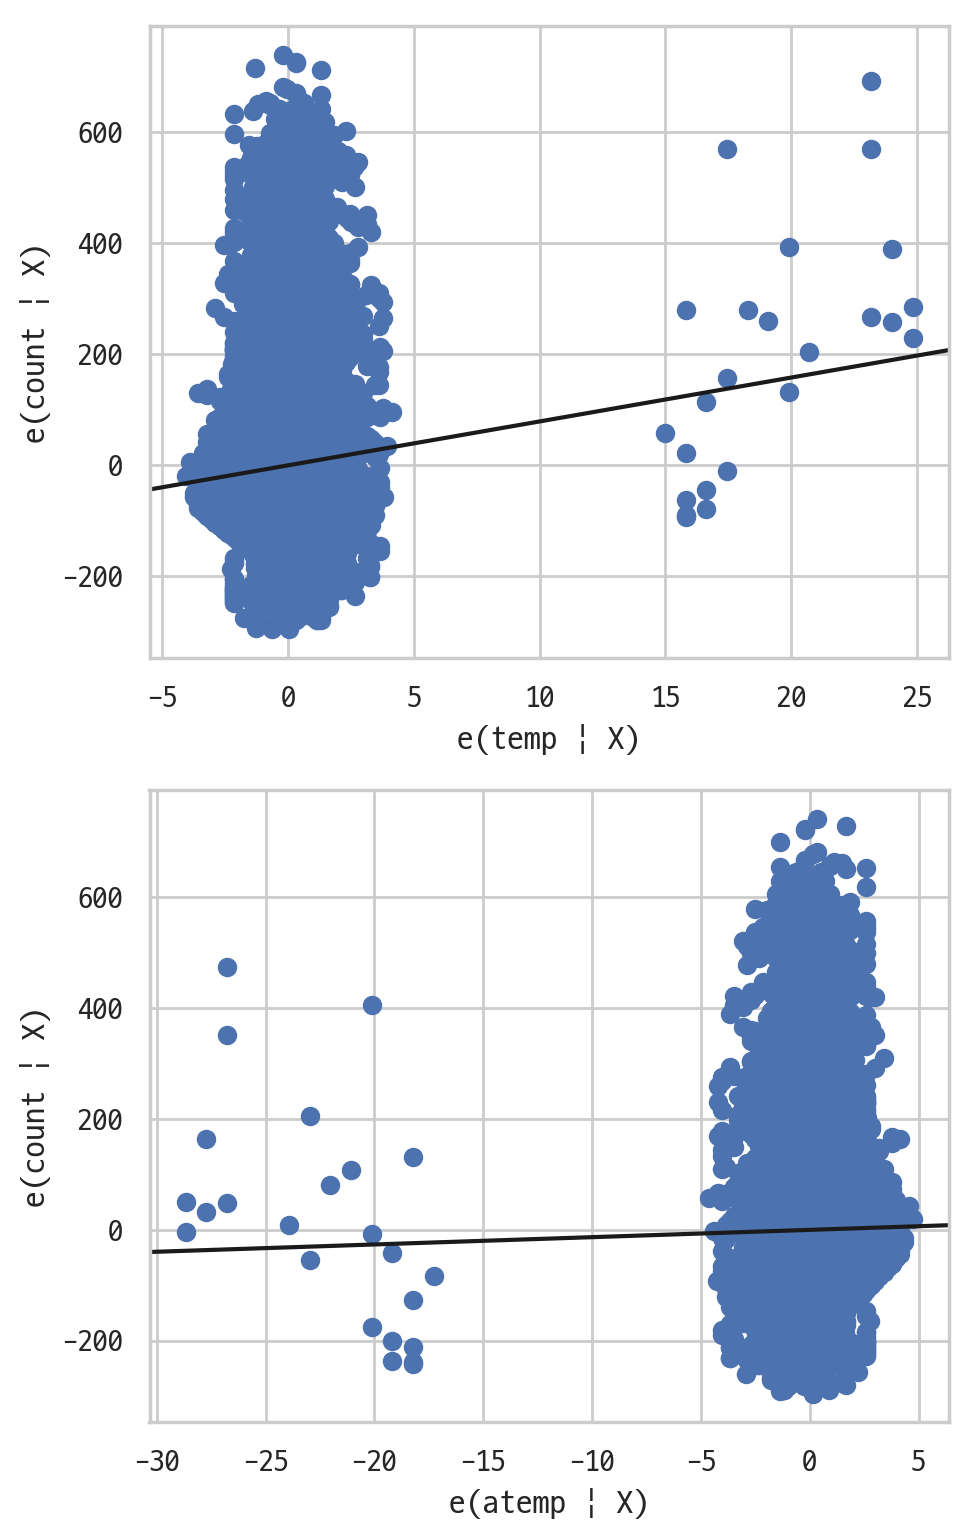

In [52]:
fig = plt.figure(figsize=(5, 8))
sm.graphics.plot_partregress_grid(result_partial, fig=fig)
fig.suptitle("")
plt.show()

In [53]:
print(result_partial.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     8212.
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:26   Log-Likelihood:                -71125.
No. Observations:               10886   AIC:                         1.423e+05
Df Residuals:                   10884   BIC:                         1.423e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           7.9074      1.135      6.965      0.0

> atemp를 버리고 다시 다중공선성 체크를 해본다.

In [54]:
train_vif = train_vif.drop(columns='atemp')

In [55]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif = vif.sort_values(by=["VIF Factor"], ascending=False).reset_index(drop=True)
vif

,VIF Factor,features
0,109.600102,season
1,83.686455,month
2,70.125617,year
3,18.427083,humidity
4,9.124789,day_of_week
5,8.986697,workingday
6,8.595359,temp
7,7.673746,weather
8,5.696462,windspeed
9,4.336546,day


이제는 season과 month의 강한 상관관계가 예상되는 상황이다. 두 범주형 데이터를 하나씩 모델에서 빼보고 더 성능이 좋아지는 변수를 선택한다.

결정계수 값이 season을 넣었을 때는 0.832, month를 넣었을 때는 0.835이므로 season 변수를 제거한다.

In [56]:
model2 = sm.OLS.from_formula('np.log1p(count) ~ C(holiday) + C(workingday) + C(weather) +\
scale(temp) + scale(humidity) + scale(windspeed) + C(year) + C(month) + C(hour) + C(day) + C(day_of_week) + 0', train)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     828.7
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:31   Log-Likelihood:                -9456.7
No. Observations:               10886   AIC:                         1.905e+04
Df Residuals:                   10819   BIC:                         1.954e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(holiday)[0]           2.2970    

In [57]:
train_vif = train_vif.drop(columns='season')

In [58]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif = vif.sort_values(by=["VIF Factor"], ascending=False).reset_index(drop=True)
vif

,VIF Factor,features
0,66.455631,year
1,18.381747,humidity
2,9.123513,day_of_week
3,8.986512,workingday
4,8.586329,temp
5,7.672263,weather
6,5.693013,windspeed
7,5.253372,month
8,4.336545,day
9,4.247442,hour


atemp와 season 변수를 제거한 후 다중공선성을 확인해보면 year의 vif factor가 상대적으로 높다고 판단되어 모델에서 빼보았지만 결정계수가 0.835에서 0.805로 현저히 낮아지므로 일단 모형에 포함시키기로 한다.

또한 hour이 cycle을 가진 변수라고 생각되어 아래와 같이 주기성을 넣어 모델에 적용해보았으나 오히려 성능이 떨어져서 그냥 범주형 변수로 고려하기로 한다.

In [59]:
model3 = sm.OLS.from_formula('np.log1p(count) ~ C(holiday) + C(workingday) + C(weather) + scale(temp)\
+ scale(humidity) + scale(windspeed) + C(year) + C(month) + C(day) + C(day_of_week)\
+ scale(np.sin(I(2*np.pi*(hour/24)))) * scale(np.cos(I(2*np.pi*(hour/24))))\
+ 0', train)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     767.9
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:33   Log-Likelihood:                -11372.
No. Observations:               10886   AIC:                         2.284e+04
Df Residuals:                   10839   BIC:                         2.318e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [60]:
train_vif.columns

Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'year', 'month', 'hour', 'day', 'day_of_week'],
      dtype='object')

모델에서 여전히 조건수가 높으므로 범주형 변수들의 상관관계를 생각해보면, holiday와 workingday, day_of_week 는 서로 상당히 연관되어 있는 변수들임을 알 수 있다. 따라서 그 세 변수 중 하나만 남기고 나머지는 제거한다. 또한 위에서 확인했듯 일별 자전거 대여수는 별로 차이가 없었기 때문에 day 변수도 삭제한다.

In [61]:
model4 = sm.OLS.from_formula('np.log1p(count) ~ C(workingday) + C(weather) + scale(temp) + scale(humidity) + \
scale(windspeed) + C(year) + C(month) + C(hour) + 0', train)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1285.
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:27:33   Log-Likelihood:                -9526.8
No. Observations:               10886   AIC:                         1.914e+04
Df Residuals:                   10843   BIC:                         1.945e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(workingday)[0]     3.1068      0.041  

> 이번 모델에서 조건수가 현저히 낮아졌고 성능도 올랐음을 확인할 수 있다.

마지막으로 temp와 windspeed에 로그처리를 해 주자 0.01이 더 올랐다.

In [71]:
model5 = sm.OLS.from_formula('np.log1p(count) ~ C(workingday) + C(weather) + C(hour) + scale(np.log(temp)) \
+ C(month) + scale(humidity) + scale(np.log(windspeed)) + C(year) + 0', train)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1294.
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:33:13   Log-Likelihood:                -9494.3
No. Observations:               10886   AIC:                         1.907e+04
Df Residuals:                   10843   BIC:                         1.939e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(workingday)[0]        

### 아웃라이어 처리

In [63]:
from statsmodels.graphics import utils

In [64]:
dfX0 = train[['month','temp','weather','humidity','workingday','hour','windspeed','year']]
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(train['count'])

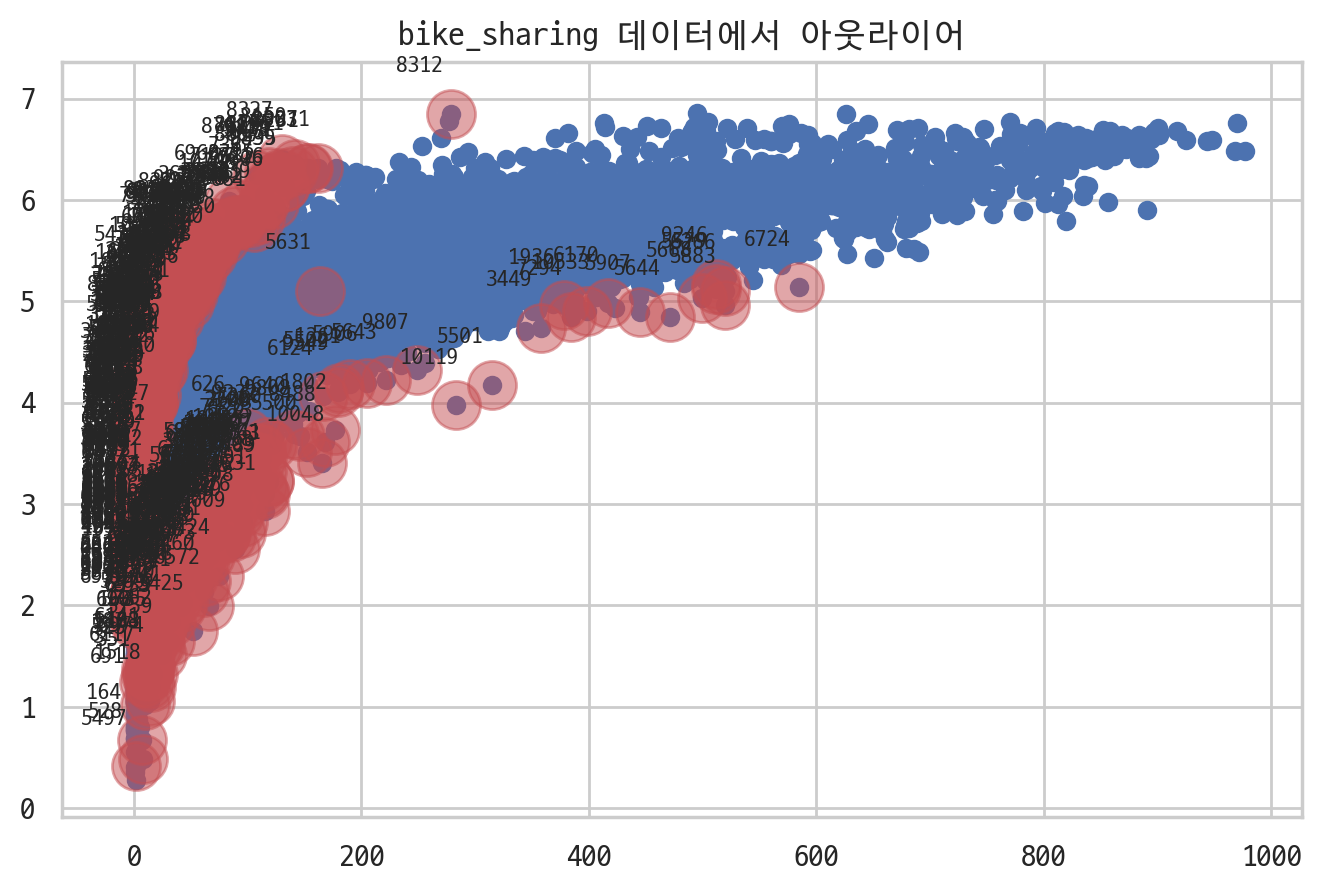

In [65]:
pred = result5.predict(dfX)

influence_count = result5.get_influence()
cooks_d2, pvals = influence_count.cooks_distance
fox_cr = 4 / (len(dfy) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy['count'][idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy['count'][idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("bike_sharing 데이터에서 아웃라이어")
plt.show()

In [68]:
idx2 = list(set(range(len(dfX))).difference(idx))
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)

In [69]:
dfX['count'] = dfy

In [70]:
dfX.tail()

,const,month,temp,weather,humidity,workingday,hour,windspeed,year,count
9614,1.0,12,15.58,1,50.0,1,19,26.0027,2012,336
9615,1.0,12,14.76,1,57.0,1,20,15.0013,2012,241
9616,1.0,12,13.94,1,61.0,1,21,15.0013,2012,168
9617,1.0,12,13.94,1,61.0,1,22,6.0032,2012,129
9618,1.0,12,13.12,1,66.0,1,23,8.9981,2012,88


In [993]:
weather_4 = train[train.weather==4].drop(columns = ['season','holiday','atemp','casual','registered','day','y_m_d',
                                                    'day_of_week'])
weather_4['const'] = 1.0

In [994]:
weather_4.tail()

,workingday,weather,temp,humidity,windspeed,count,year,month,hour,const
5631,1,4,8.2,86.0,6.0032,164,2012,1,18,1.0


In [995]:
dfX = dfX.append(weather_4).reset_index()

In [1004]:
dfX = dfX.drop(columns='index')

> 아웃라이어 제거 후 변수간 상호작용까지 고려하여 마지막으로 완성된 모델은 다음과 같다.

In [96]:
model6 = sm.OLS.from_formula('np.log1p(count) ~ C(workingday) + C(weather) + C(hour) / scale(np.log(temp)) \
+ C(month) / scale(humidity) + scale(np.log(windspeed)) + C(day_of_week) + C(year) + 0', train)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     683.5
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:42:16   Log-Likelihood:                -9338.6
No. Observations:               10886   AIC:                         1.884e+04
Df Residuals:                   10803   BIC:                         1.945e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(workingd

### 교차검증

In [1006]:
from sklearn.model_selection import KFold

In [1007]:
df = dfX

In [1010]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=5)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]
    model = sm.OLS.from_formula('np.log1p(count) ~ C(workingday) + C(weather) + C(hour) / scale(np.log(temp)) \
+ C(month) / scale(humidity) + scale(np.log(windspeed)) + C(year) + 0', df_train)
    result = model.fit()
    
    yhat = np.exp(result.predict(df_test)) -1
    rss = ((df_test['count'] - yhat) ** 2).sum()
    tss = ((df_test['count'] - df_test['count'].mean())** 2).sum()
    rsquared = 1 - rss / tss
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

학습 R2 = 0.90313394, 검증 R2 = 0.76287341
학습 R2 = 0.90061001, 검증 R2 = 0.78351560
학습 R2 = 0.90201332, 검증 R2 = 0.77214832


PatsyError: Error converting data to categorical: observation with value 4 does not match any of the expected levels (expected: [1, 2, 3])
    np.log1p(count) ~ C(workingday) + C(weather) + C(hour) / scale(np.log(temp)) + C(month) / scale(humidity) + scale(np.log(windspeed)) + C(year) + 0
                                      ^^^^^^^^^^

> weather값이 4인 데이터가 하나밖에 없어서 트레인데이터 내에서 교차검증 시 계속 에러가 나는 것 같다.

## 테스트 데이터 전처리

In [74]:
test = pd.read_csv("test.csv")
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [75]:
test.datetime = pd.to_datetime(test.datetime)

In [76]:
test['year'] = test.datetime.apply(lambda x : x.year)

In [77]:
test['month'] = test.datetime.apply(lambda x : x.month)

In [78]:
test['hour'] = test.datetime.apply(lambda x : x.hour)

In [79]:
test['day'] = test.datetime.apply(lambda x : x.day)

In [80]:
test['y_m_d'] = test.datetime.apply(lambda x : x.date())

In [81]:
test['day_of_week'] = test.datetime.apply(lambda x : x.weekday())

In [82]:
windspeed_mean = test[['windspeed','y_m_d']].groupby(by='y_m_d').agg('mean')
windspeed_mean = windspeed_mean.rename(columns={'windspeed':'windspeed_mean'})

In [83]:
test = pd.merge(test, windspeed_mean, on='y_m_d')

In [84]:
new = test.windspeed.values

In [85]:
for i in range(len(new)):
    if new[i] == 0:
        new[i] = test.windspeed_mean.values[i]

In [86]:
test.windspeed = new

In [87]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,day,y_m_d,day_of_week,windspeed_mean
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011,1,0,20,2011-01-20,3,13.125579
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,13.125579,2011,1,1,20,2011-01-20,3,13.125579
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,13.125579,2011,1,2,20,2011-01-20,3,13.125579
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,3,20,2011-01-20,3,13.125579
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,4,20,2011-01-20,3,13.125579


In [88]:
test = test.drop(columns=['datetime', 'windspeed_mean'])

In [97]:
pred = np.exp(result6.predict(test)) -1

In [90]:
len(pred)

6493

In [98]:
submit = pd.read_csv('sampleSubmission.csv')
submit['count'] = pred

In [99]:
submit.tail()

,datetime,count
6488,2012-12-31 19:00:00,246.735445
6489,2012-12-31 20:00:00,178.881916
6490,2012-12-31 21:00:00,146.371645
6491,2012-12-31 22:00:00,120.749551
6492,2012-12-31 23:00:00,76.943860


In [100]:
submit.to_csv('sampleSubmission.csv', index=False)

![image](https://user-images.githubusercontent.com/44221498/49863210-231a7300-fe43-11e8-8134-b3f52cd3acba.png)


아웃라이어 제거 안하고 했을 때

![image](https://user-images.githubusercontent.com/44221498/49864670-590d2680-fe46-11e8-9da1-167857f8e49d.png)


'day of week' 변수 포함시켰을 때

![image](https://user-images.githubusercontent.com/44221498/49864789-a093b280-fe46-11e8-9577-b2457d862f99.png)
